Import packages

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Time series models
from prophet import Prophet

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluation metrics
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

# Plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times New Roman'

Data preparation

In [4]:
# Load and prepare data
df = pd.read_csv('../data/energydata_complete_cleaned.csv', parse_dates=['date'], index_col='date')
df.sort_index(inplace=True)
print('Data shape: ', df.shape)
print('Date range:', df.index.min(), 'to', df.index.max())

# Define features and target variable
features = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 
            'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 
            'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 
            'Visibility', 'Tdewpoint', 'rv1', 
            'is_weekend', 'hour_sin', 'hour_cos', 'day_of_week_sin', 
            'day_of_week_cos', 'Appliances_lag1', 'Appliances_rolling_mean_6']
target = 'Appliances'
print('Feature number: ', len(features))

# For time series models, we'll use chronological split
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

print('Training data shape: ', train_df.shape)
print('Testing data shape: ', test_df.shape)
print('Training period:', train_df.index.min(), 'to', train_df.index.max())
print('Testing period:', test_df.index.min(), 'to', test_df.index.max())

# Prepare Prophet format data
prophet_train = train_df.reset_index().rename(columns={'date': 'ds', target: 'y'})#[['ds', 'y']]
prophet_test = test_df.reset_index().rename(columns={'date': 'ds', target: 'y'})#[['ds', 'y']]

print('\nProphet training data shape:', prophet_train.shape)
print('Prophet testing data shape:', prophet_test.shape)

Data shape:  (19591, 38)
Date range: 2016-01-12 17:00:00 to 2016-05-27 18:00:00
Feature number:  33
Training data shape:  (15672, 38)
Testing data shape:  (3919, 38)
Training period: 2016-01-12 17:00:00 to 2016-04-30 12:50:00
Testing period: 2016-04-30 13:00:00 to 2016-05-27 18:00:00

Prophet training data shape: (15672, 39)
Prophet testing data shape: (3919, 39)


In [5]:
# Initialize results dictionary
model_results = {}

def evaluate_model(y_true, y_pred, model_name):
    """Calculate evaluation metrics for a model"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    results = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    model_results[model_name] = results
    
    print(f"\n{model_name} Results:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    
    return results

Prophet Model

In [6]:
# Initialize Prophet model
prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,  # no yearly seasonality due to limited data period
    seasonality_mode='additive'
)

# Add additional regressors
regressor_features = [f for f in features if f != target]
for feature in regressor_features:
    prophet_model.add_regressor(feature)

# Fit the model
prophet_model.fit(prophet_train)

# Make predictions
future_df_for_prediction = prophet_test[['ds'] + regressor_features]
prophet_forecast = prophet_model.predict(future_df_for_prediction)
prophet_predictions = prophet_forecast['yhat'].values

# Evaluate Prophet model
prophet_results = evaluate_model(prophet_test['y'].values, prophet_predictions, 'Prophet')


17:35:40 - cmdstanpy - INFO - Chain [1] start processing
17:35:44 - cmdstanpy - INFO - Chain [1] done processing



Prophet Results:
MSE: 3615.06
RMSE: 60.13
MAE: 27.27
R²: 0.5313


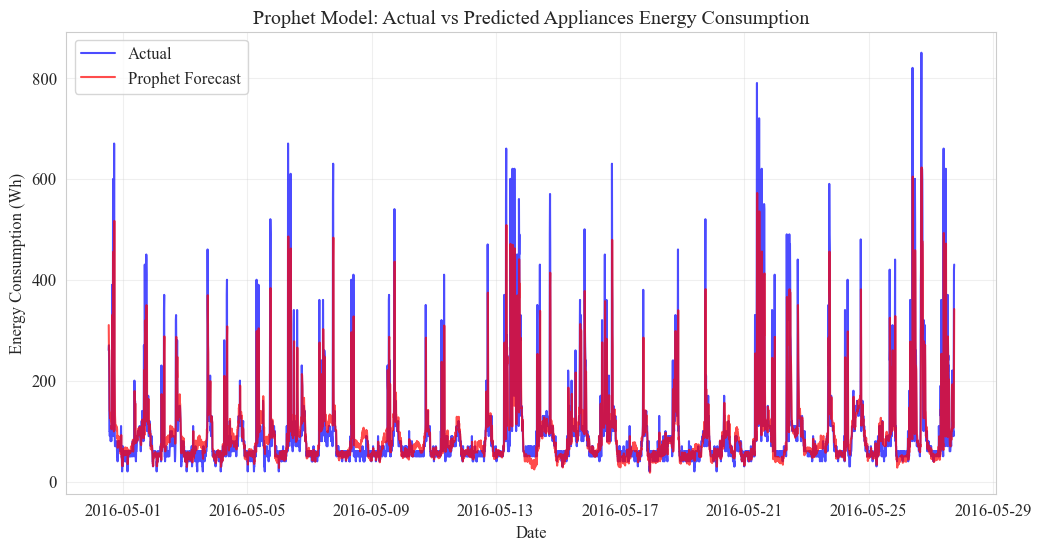

In [8]:
# Visualize Prophet results
plt.figure(figsize=(12, 6))

# Plot 1: Forecast vs Actual
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual', color='blue', alpha=0.7)
plt.plot(prophet_test['ds'], prophet_predictions, label='Prophet Forecast', color='red', alpha=0.7)
plt.title('Prophet Model: Actual vs Predicted Appliances Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (Wh)')
plt.legend()
plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.savefig('../results/prediction_plots/prophet_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Prophet components
# fig = prophet_model.plot_components(prophet_forecast)
# plt.savefig('../results/prediction_plots/prophet_components.png', dpi=300, bbox_inches='tight')
# plt.show()

SARIMA Model

In [14]:
order = (0, 1, 0)  # (p, d, q)
seasonal_order = (0, 0, 0, 0) # (P, D, Q, S)

sarimax_train_endog = train_df[target]                # SARIMAX endogenous variable
sarimax_train_exog = train_df[regressor_features]     # SARIMAX exogenous variables

sarimax_test_endog = test_df[target]                  # SARIMAX endogenous variable
sarimax_test_exog = test_df[regressor_features]       # SARIMAX exogenous variables

print('\nSARIMAX training endog shape:', sarimax_train_endog.shape)
print('SARIMAX training exog shape:', sarimax_train_exog.shape)
print('SARIMAX testing endog shape:', sarimax_test_endog.shape)
print('SARIMAX testing exog shape:', sarimax_test_exog.shape)

sarimax_model = SARIMAX(
    endog=sarimax_train_endog,
    exog=sarimax_train_exog,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False, # 可以尝试True，如果模型收敛困难，可以设置为False
    enforce_invertibility=False # 同上
)

# Fit the model
sarimax_results = sarimax_model.fit(disp=True) 

# Make predictions
sarimax_predictions = sarimax_results.predict(
    start=len(sarimax_train_endog),
    end=len(df) - 1,
    exog=sarimax_test_exog
)

sarimax_predictions.index = sarimax_test_endog.index

sarimax_eval_results = evaluate_model(sarimax_test_endog.values, sarimax_predictions.values, 'SARIMAX')


SARIMAX training endog shape: (15672,)
SARIMAX training exog shape: (15672, 33)
SARIMAX testing endog shape: (3919,)
SARIMAX testing exog shape: (3919, 33)


/Users/ruiling/PythonProjects/Foundation_of_AI/Appliances-Energy-Consumption-Forecasting-Using-Time-Series-Machine-Learning/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Users/ruiling/PythonProjects/Foundation_of_AI/Appliances-Energy-Consumption-Forecasting-Using-Time-Series-Machine-Learning/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.99215D+00    |proj g|=  1.14533D-04


 This problem is unconstrained.



At iterate    1    f=  6.13341D+00    |proj g|=  5.01251D-03
  ys=-4.103E+01  -gs= 9.804E-01 BFGS update SKIPPED

At iterate    2    f=  6.13322D+00    |proj g|=  4.90892D-03

At iterate    3    f=  6.13291D+00    |proj g|=  4.90951D-03

At iterate    4    f=  6.13197D+00    |proj g|=  1.41102D-02

At iterate    5    f=  6.12966D+00    |proj g|=  2.85411D-02

At iterate    6    f=  6.12360D+00    |proj g|=  5.27603D-02

At iterate    7    f=  6.10844D+00    |proj g|=  9.34286D-02

At iterate    8    f=  6.07239D+00    |proj g|=  1.66801D-01

At iterate    9    f=  5.99960D+00    |proj g|=  3.01192D-01

At iterate   10    f=  5.89349D+00    |proj g|=  3.26147D-01

At iterate   11    f=  5.74372D+00    |proj g|=  3.25699D-01

At iterate   12    f=  5.68734D+00    |proj g|=  1.20833D-01

At iterate   13    f=  5.66710D+00    |proj g|=  5.32021D-02

At iterate   14    f=  5.66372D+00    |proj g|=  2.62588D-02

At iterate   15    f=  5.66295D+00    |proj g|=  2.01270D-03

At iterate   16  

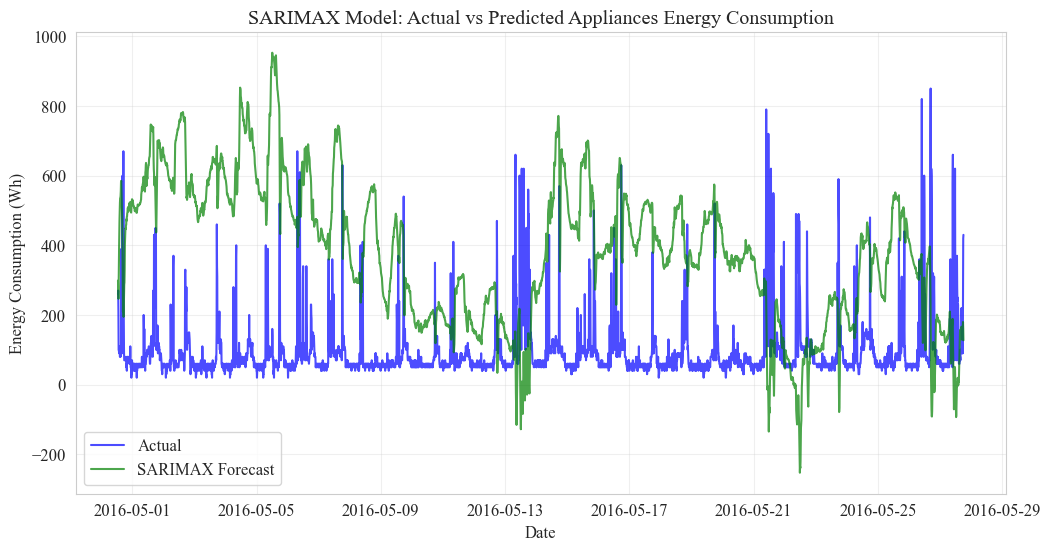

In [15]:
plt.figure(figsize=(12, 6))

plt.plot(sarimax_test_endog.index, sarimax_test_endog.values, label='Actual', color='blue', alpha=0.7)
plt.plot(sarimax_predictions.index, sarimax_predictions.values, label='SARIMAX Forecast', color='green', alpha=0.7)
plt.title('SARIMAX Model: Actual vs Predicted Appliances Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (Wh)')
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('../results/prediction_plots/sarimax_results.png', dpi=300, bbox_inches='tight')
plt.show()


Model comparison

In [16]:
print("\n--- All Model Results ---")
for model_name, metrics in model_results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


--- All Model Results ---

Prophet:
  MSE: 3615.0616
  RMSE: 60.1254
  MAE: 27.2655
  R2: 0.5313

SARIMAX:
  MSE: 136075.0162
  RMSE: 368.8835
  MAE: 321.3249
  R2: -16.6414
